In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
dataset_url = 'https://raw.githubusercontent.com/samofuture/ML-Final-Project/main/dataset.csv'

def prep_data() -> pd.DataFrame:
    df = pd.read_csv(dataset_url)
    df['Target'] = df['Target'].apply(lambda x: 2 if x == 'Graduate' else 1 if x == 'Enrolled' else 0)
    return df

df = prep_data()
target = df.pop('Target').to_numpy()

In [3]:
# PCA
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(df)
df = pd.DataFrame(data=principalComponents)

scaler_x = StandardScaler()
data = scaler_x.fit_transform(df)

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2, random_state=15)

train_inputs = torch.tensor(np.array(X_train)).float()
train_outputs = torch.tensor(Y_train).long()
val_inputs = torch.tensor(np.array(X_test)).float()
val_outputs = torch.tensor(Y_test).long()

In [7]:
# Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, num_inputs):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(num_inputs, 3)  # 3 classes for 'Dropout', 'Enrolled', 'Graduate'

    def forward(self, x):
        return self.linear(x)

def training_loop(num_epochs, optimizer, loss_fn, model, t_in, t_out, v_in, v_out):
    valid_acc = []
    valid_losses = []
    train_acc = []
    train_losses = []

    for epoch in range(1, num_epochs + 1):
        t_p = model(t_in)
        train_loss = loss_fn(t_p, t_out)
        train_losses.append(float(train_loss))
        v_p = model(v_in)
        val_loss = loss_fn(v_p, v_out)
        valid_losses.append(float(val_loss))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        t_acc = metrics.accuracy_score(t_out, torch.argmax(t_p, dim=1).numpy())
        train_acc.append(t_acc)

        val_acc = metrics.accuracy_score(v_out, torch.argmax(v_p, dim=1).numpy())
        valid_acc.append(val_acc)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}:")
            print(f"\tTraining Loss: {float(train_loss)}")
            print(f"\tValidation Loss: {float(val_loss)}")
            print(f"\tValidation Accuracy: {float(val_acc)}")

    x_range = range(num_epochs)
    plt.plot(x_range, valid_acc, label='Validation Accuracy')
    plt.plot(x_range, train_acc, label='Training Accuracy')

    plt.title('Validation/Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(x_range, valid_losses, label='Validation Loss')
    plt.plot(x_range, train_losses, label='Training Loss')

    plt.title('Validation/Training Losses per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


Epoch 100:
	Training Loss: 1.1718257665634155
	Validation Loss: 1.1713355779647827
	Validation Accuracy: 0.327683615819209
Epoch 200:
	Training Loss: 1.1481258869171143
	Validation Loss: 1.1496894359588623
	Validation Accuracy: 0.3559322033898305
Epoch 300:
	Training Loss: 1.1255459785461426
	Validation Loss: 1.1289939880371094
	Validation Accuracy: 0.38305084745762713
Epoch 400:
	Training Loss: 1.104020357131958
	Validation Loss: 1.1092205047607422
	Validation Accuracy: 0.40451977401129946
Epoch 500:
	Training Loss: 1.0834957361221313
	Validation Loss: 1.0903215408325195
	Validation Accuracy: 0.4293785310734463
Epoch 600:
	Training Loss: 1.0639251470565796
	Validation Loss: 1.0722570419311523
	Validation Accuracy: 0.45084745762711864
Epoch 700:
	Training Loss: 1.0452649593353271
	Validation Loss: 1.0549945831298828
	Validation Accuracy: 0.46214689265536724
Epoch 800:
	Training Loss: 1.027474284172058
	Validation Loss: 1.038506031036377
	Validation Accuracy: 0.4824858757062147
Epoch 90

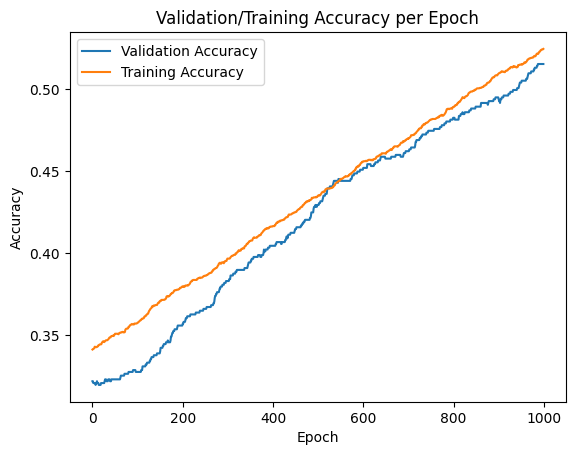

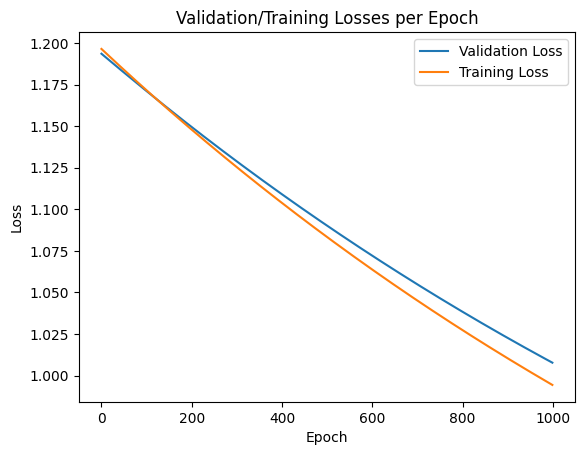

In [11]:
       # Model, optimizer, and loss function
model = LogisticRegressionModel(20)  # Adjust the input size according to your PCA components
optimizer = optim.Adam(model.parameters(), lr=0.000075)
loss_fn = nn.CrossEntropyLoss()

# Training
trained_model = training_loop(1000, optimizer, loss_fn, model, train_inputs, train_outputs, val_inputs, val_outputs)

# Evaluation
raw_outputs = trained_model(val_inputs)
_, predicted_classes = torch.max(raw_outputs, 1)
acc = metrics.accuracy_score(val_outputs, predicted_classes)



              precision    recall  f1-score   support

           0       0.42      0.50      0.46       278
           1       0.25      0.27      0.26       157
           2       0.71      0.61      0.66       450

    accuracy                           0.52       885
   macro avg       0.46      0.46      0.46       885
weighted avg       0.54      0.52      0.52       885



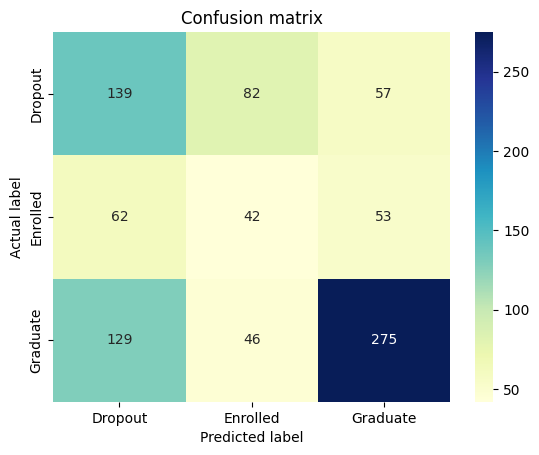

In [14]:
print(metrics.classification_report(val_outputs, predicted_classes))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cnf_matrix = confusion_matrix(val_outputs, predicted_classes)
class_names = ['Dropout', 'Enrolled', 'Graduate']

# Plot Confusion Matrix
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()